##Melbourne Housing Project
###Content
0. Import library & utils
1. Descriptive analysis
2. Apply linear regression model for prediction with hold out & cross validation
3. Apply linear regression model for prediction with hold out & cross validation - using PCA
4. Visualize residential & homoscedasticity
5. Tune parameter of linear regression model
6. Summary

#### Data definition on Kaggle
Some Key Details

Suburb: Suburb

Address: Address

Rooms: Number of rooms

Price: Price in Australian dollars

Method: 
S - property sold; 
SP - property sold prior; 
PI - property passed in; 
PN - sold prior not disclosed; 
SN - sold not disclosed; 
NB - no bid; 
VB - vendor bid; 
W - withdrawn prior to auction; 
SA - sold after auction; 
SS - sold after auction price not disclosed. 
N/A - price or highest bid not available.

Type:
br - bedroom(s); 
h - house,cottage,villa, semi,terrace; 
u - unit, duplex;
t - townhouse; 
dev site - development site; 
o res - other residential.

SellerG: Real Estate Agent

Date: Date sold

Distance: Distance from CBD in Kilometres

Regionname: General Region (West, North West, North, North east …etc)

Propertycount: Number of properties that exist in the suburb.

Bedroom2 : Scraped # of Bedrooms (from different source)

Bathroom: Number of Bathrooms

Car: Number of carspots

Landsize: Land Size in Metres

BuildingArea: Building Size in Metres

YearBuilt: Year the house was built

CouncilArea: Governing council for the area

Lattitude: Self explanitory

Longtitude: Self explanitory

### 0. Import library & utils

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import math
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.stats import f_oneway
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

##### utils

In [2]:
def box_cox_transfrom(df,train_var,pred_var):
  bx = PowerTransformer(method='box-cox')
  train_list = np.array(df[train_var]).reshape(-1,1)
  bx_transform = bx.fit(train_list)
  return bx_transform.transform(np.array(df[pred_var]).reshape(-1,1))+100

def col_filtering(df,col):
  list_col = ['Lattitude','Longtitude']
  if col in list_col:
    temp_list = df
    temp_list[col] = round(abs(temp_list[col]),4)
    temp_list = temp_list[temp_list[col]>0]
  else:
    temp_list = df[df[col]>0]
  return temp_list

# scaler = preprocessing.MinMaxScaler()

def scaleColumns(df_scale, cols_to_scale):
    for col in cols_to_scale:
      minmax_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
      df_scale[col] = pd.DataFrame(minmax_scaler.fit_transform(pd.DataFrame(df_scale[col])),columns=[col])
      df_scale[col].fillna(0,inplace=True)
    return df_scale

def yearbuild_grp(var):
  if math.isnan(var)==True:
    return 0
  elif int(var)<=1850:
    return 1
  elif int(var)>1850 & int(var)<=1900:
    return 2
  elif int(var)>1900 & int(var)<=1950:
    return 3
  elif int(var)>1950:
    return 4

def cat_transform(target_cat,cat_list):
  for i,c in enumerate(cat_list):
    if target_cat==c:
      return i

###1. Descriptive analysis
#### Inclduing:
####1.1 Describe data and null handling
####1.2 Visualize and correlation finding

In [87]:
# Import data & examine data interity
df = pd.read_csv('Melbourne_housing_FULL.csv')
print(df.shape)
df.info()
print(df.describe(include="O").T)
df.describe()

(34857, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34857.000000,2.724700e+04,34856.000000,34856.000000,26640.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000,26881.000000,26881.000000,34854.000000
mean,3.031012,1.050173e+06,11.184929,3116.062859,3.084647,1.624798,1.728845,593.598993,160.25640,1965.289885,-37.810634,145.001851,7572.888306
std,0.969933,6.414671e+05,6.788892,109.023903,0.980690,0.724212,1.010771,3398.841946,401.26706,37.328178,0.090279,0.120169,4428.090313
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.350000e+05,6.400000,3051.000000,2.000000,1.000000,1.000000,224.000000,102.00000,1940.000000,-37.862950,144.933500,4385.000000
50%,3.000000,8.700000e+05,10.300000,3103.000000,3.000000,2.000000,2.000000,521.000000,136.00000,1970.000000,-37.807600,145.007800,6763.000000
75%,4.000000,1.295000e+06,14.000000,3156.000000,4.000000,2.000000,2.000000,670.000000,188.00000,2000.000000,-37.754100,145.071900,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,30.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000,-37.390200,145.526350,21650.000000


In [88]:
df.isnull().sum()/(df.shape[0])

Suburb           0.000000
Address          0.000000
Rooms            0.000000
Type             0.000000
Price            0.218321
Method           0.000000
SellerG          0.000000
Date             0.000000
Distance         0.000029
Postcode         0.000029
Bedroom2         0.235735
Bathroom         0.235993
Car              0.250394
Landsize         0.338813
BuildingArea     0.605761
YearBuilt        0.553863
CouncilArea      0.000086
Lattitude        0.228821
Longtitude       0.228821
Regionname       0.000086
Propertycount    0.000086
dtype: float64

#####+Remark
######1. Data has 21 columns & 34857 rows.
######2. Columns with null value: Price (27247/34857), Distant (34856/34857), Postcode (34856/34857), Bedroom2 (26640/34857), Bathroom (26631/34857), Car (26129/34857), Landsize (23047/34857), Buiding Area (13742/34857), Yearbuild (15551/34857), CouncilArea (34854/34857), Lattitue (26881/34857), Longtitue (26881/34857), Regionname (34854/34857), Propertycount (34854/34857)
    ----> Drop NA value of dependent variables Price (21% - acceptable proportion) since the target var should not be manipulated on prediction model
    ----> Drop row for null value at columns: Distance, Postcode, CouncilArea, Regionname, Propertycount.
    ----> Fill Null value for Bedroom2, Bathroom, Car, Landsize, Yearbuild, Lat/long, BuidingArea.
    ----> For object vars: label encoding & check linear relationship.


In [89]:
# drop na row in Price
df = df.dropna(subset=['Price'])

In [90]:
# drop null rows
drop_col = ['Distance','Postcode','CouncilArea','Regionname','Propertycount']
for c in drop_col:
  df.drop(df[df[c].isnull()].index, inplace=True)
df[drop_col].info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27244 entries, 1 to 34856
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Distance       27244 non-null  float64
 1   Postcode       27244 non-null  float64
 2   CouncilArea    27244 non-null  object 
 3   Regionname     27244 non-null  object 
 4   Propertycount  27244 non-null  float64
dtypes: float64(3), object(2)
memory usage: 2.5+ MB
(27244, 21)


In [91]:
# fill na
fill_col = ['Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Lattitude','Longtitude','YearBuilt']
print("======="+"Mode"+"=======")
print(df[fill_col].mode().T)
print(df['YearBuilt'].mode().T)
print("======="+"Quantile"+"=======")
print(df[fill_col[0:4]].describe())
print(df[fill_col[5:8]].describe())

=======Mode=======
                      0
Bedroom2         3.0000
Bathroom         1.0000
Car              2.0000
Landsize         0.0000
BuildingArea   120.0000
Lattitude      -37.8361
Longtitude     144.9966
YearBuilt     1970.0000
0    1970.0
dtype: float64
=======Quantile=======
           Bedroom2      Bathroom           Car       Landsize
count  20806.000000  20800.000000  20423.000000   17982.000000
mean       3.046237      1.591683      1.715370     593.488933
std        0.955122      0.700880      0.994216    3757.266429
min        0.000000      0.000000      0.000000       0.000000
25%        2.000000      1.000000      1.000000     219.000000
50%        3.000000      1.000000      2.000000     512.000000
75%        4.000000      2.000000      2.000000     664.000000
max       20.000000      9.000000     18.000000  433014.000000
          Lattitude    Longtitude     YearBuilt
count  20993.000000  20993.000000  12084.000000
mean     -37.806963    144.996711   1966.609153
std 

========Distribution column: Bedroom2========


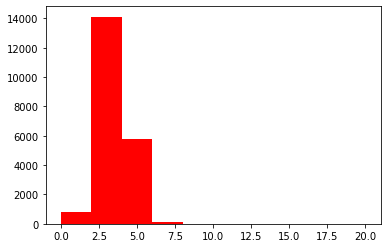

========Distribution column: Bathroom========


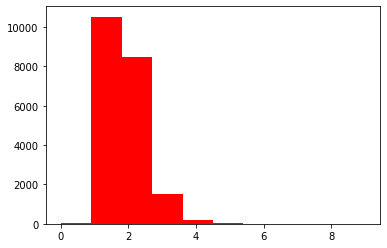

========Distribution column: Car========


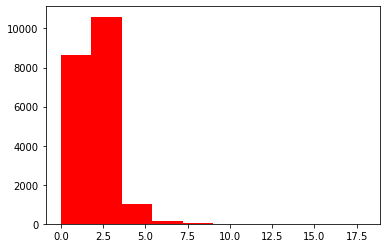

========Distribution column: Landsize========


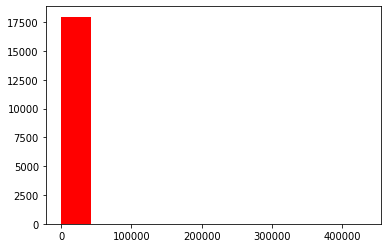

========Distribution column: BuildingArea========


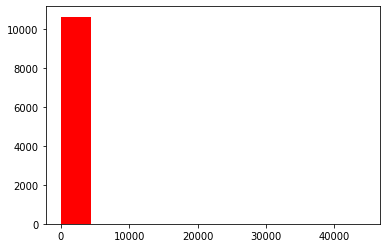

========Distribution column: Lattitude========


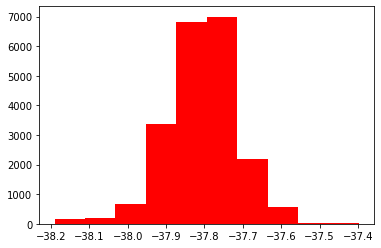

========Distribution column: Longtitude========


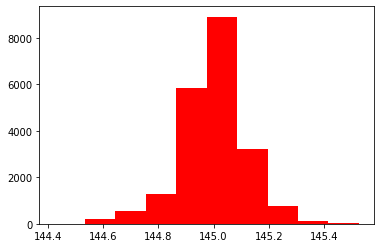

========Distribution column: YearBuilt========


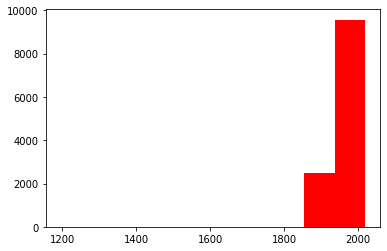

In [92]:
for col in fill_col:
  temp_df = df[df[col].notnull()]
  trg_array = np.array(temp_df[col])
  print("========Distribution column: " + col + "========")
  plt.hist(temp_df[col],color='red')
  plt.show()

######+ Remark
######- We have 3 groups to handle null value
######--> group1: fill by median: Bedroom2,Bathroom,Car,BuildingArea since the distribution of those columns are skewed.
######--> group2: fill by mean: Lattitude,Longtitude since the distribution of those columns are normal.
######--> group3: for columns YearBuilt, grouping by period including null value.

In [93]:
## group1 & 2
fill_med = ['Bedroom2','Bathroom','Car','Landsize','BuildingArea']
fill_mean = ['Lattitude','Longtitude']
for c in fill_col:
  if c in fill_med:
    df[c].fillna(df[c].median(), inplace=True)
  elif c in fill_mean:
    df[c].fillna(df[c].mean(), inplace=True)
df[fill_col].info()
df[fill_col].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27244 entries, 1 to 34856
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Bedroom2      27244 non-null  float64
 1   Bathroom      27244 non-null  float64
 2   Car           27244 non-null  float64
 3   Landsize      27244 non-null  float64
 4   BuildingArea  27244 non-null  float64
 5   Lattitude     27244 non-null  float64
 6   Longtitude    27244 non-null  float64
 7   YearBuilt     12084 non-null  float64
dtypes: float64(8)
memory usage: 3.1 MB


,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,YearBuilt
count,27244.000000,27244.000000,27244.000000,27244.000000,27244.000000,27244.000000,27244.000000,12084.000000
mean,3.035311,1.451732,1.786632,565.785567,142.322469,-37.806963,144.996711,1966.609153
std,0.834902,0.662012,0.869588,3052.714373,281.179046,0.080424,0.105934,36.762373
min,0.000000,0.000000,0.000000,0.000000,0.000000,-38.190430,144.423790,1196.000000
25%,3.000000,1.000000,1.000000,351.000000,133.000000,-37.842848,144.954300,1950.000000
50%,3.000000,1.000000,2.000000,512.000000,133.000000,-37.806963,144.996711,1970.000000
75%,3.000000,2.000000,2.000000,592.000000,133.000000,-37.766000,145.048360,2000.000000
max,20.000000,9.000000,18.000000,433014.000000,44515.000000,-37.397800,145.526350,2019.000000


In [ ]:
## group3
df_to_check_yearbuild = df[['YearBuilt','Price']]
df_to_check_yearbuild = df_to_check_yearbuild.dropna()
df_to_check_yearbuild = df_to_check_yearbuild[df_to_check_yearbuild['YearBuilt']>=1200]
df_to_check_yearbuild_med = df_to_check_yearbuild['Price'].groupby(df_to_check_yearbuild['YearBuilt']).median().reset_index(name='med_price')
plt.figure(figsize=(20,8))
plt.scatter(df_to_check_yearbuild_med['YearBuilt'],df_to_check_yearbuild_med['med_price'])
plt.show()
# print(np.quantile(df_to_check_yearbuild_med['med_price'],[0,.1,.15,.2,.25,.5,.75,.8,1]))

##### + Variables Yearbuild will be split by group:
###### 1. null value : 0
###### 2. <=1850 : 1
###### 3. >1850 - 1900 : 2
###### 4. >1900 - 1950 : 3
###### 5. >1950 : 4



In [ ]:
df['yearbuild_grp'] = df['YearBuilt'].apply(lambda x:yearbuild_grp(x))

######+Remark for zero-value columns: 
######1. For Bedroom2, Bathroom, Car: based on definition of data & correlation matrix, these columns have high correlation with Rooms --> these columns is to additional for Rooms so it is ok to keep it unchanged.
######2. For Landsize, BuildingArea: These columns are related to sizing and there is no record with both of these columns with zero --> keep unchanged as well.

In [ ]:
# Catgorical vars handling
df.describe(include=['O']).T

count    5.000000e+00
mean     5.722384e+09
std      7.228008e+09
min      1.866759e+08
25%      3.166502e+09
50%      3.204422e+09
75%      3.638712e+09
max      1.841561e+10
Name: sum_price, dtype: float64


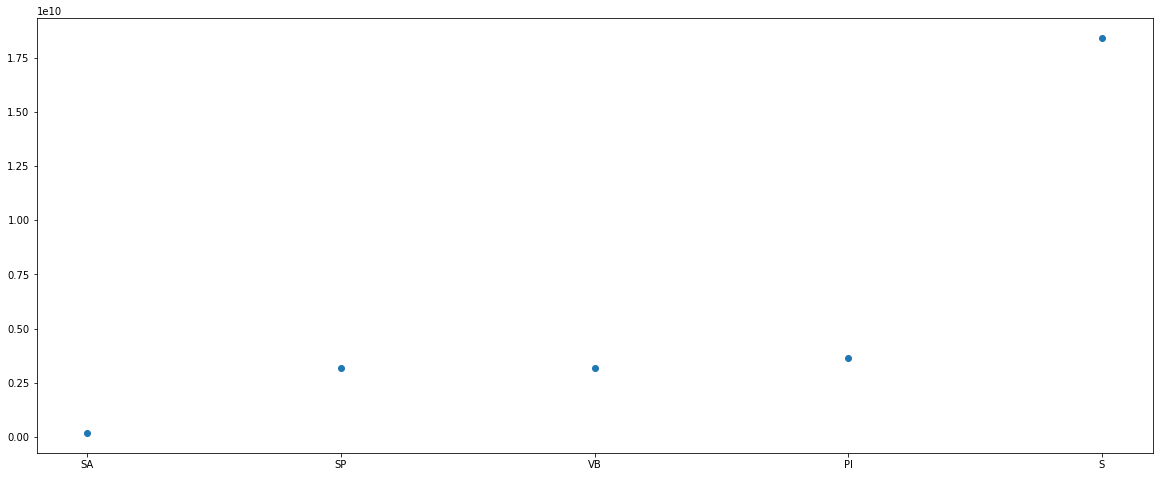

=====VAR_METHOD - ANOVA TEST: F_onewayResult(statistic=104.23207001402056, pvalue=2.9214949444110804e-88)
Reject H0
count    3.000000e+00
mean     9.537307e+09
std      1.100767e+10
min      2.668467e+09
25%      3.189138e+09
50%      3.709808e+09
75%      1.297173e+10
max      2.223365e+10
Name: sum_price, dtype: float64


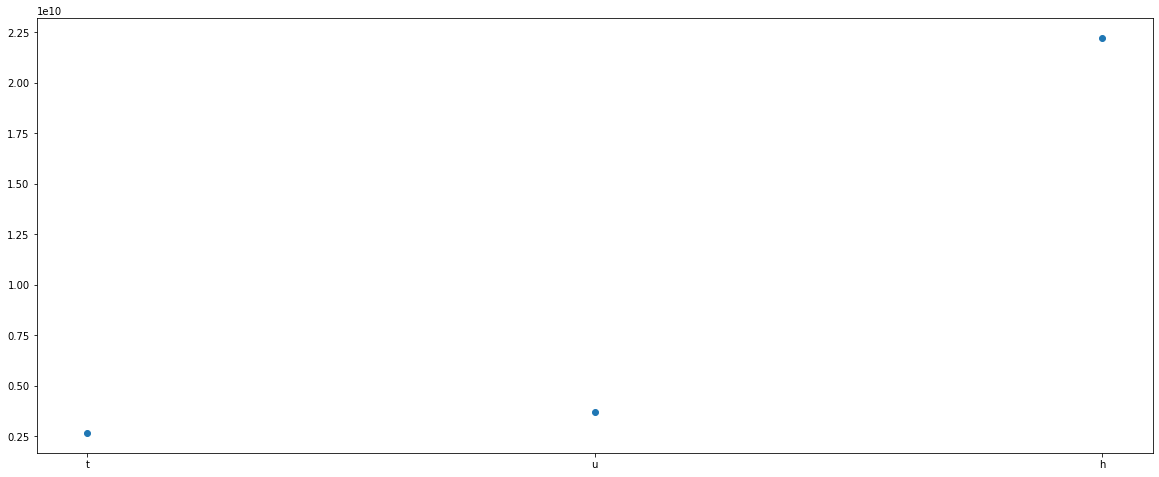

=====VAR_TYPE - ANOVA TEST: F_onewayResult(statistic=4434.219226157888, pvalue=0.0)
Reject H0
count    3.440000e+02
mean     8.317419e+07
std      1.136344e+08
min      3.800000e+05
25%      1.104088e+07
50%      3.873150e+07
75%      1.058344e+08
max      6.289999e+08
Name: sum_price, dtype: float64


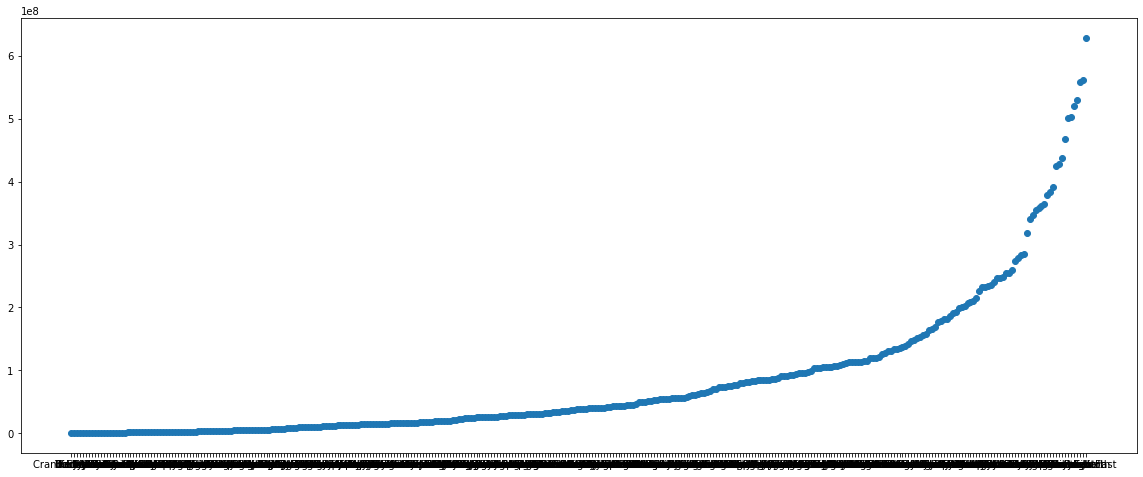

count    8.000000e+00
mean     3.576490e+09
std      4.199426e+09
min      4.153025e+07
25%      1.146245e+08
50%      2.402357e+09
75%      5.346727e+09
max      1.189889e+10
Name: sum_price, dtype: float64


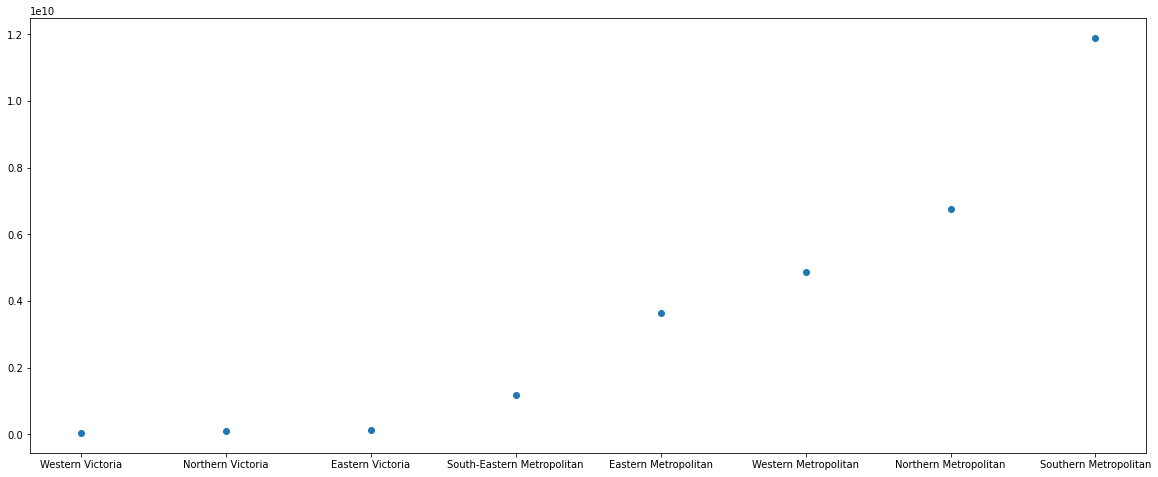

count    3.490000e+02
mean     8.198258e+07
std      3.388601e+08
min      3.250000e+05
25%      1.310000e+06
50%      4.260000e+06
75%      1.906600e+07
max      3.419375e+09
Name: sum_price, dtype: float64


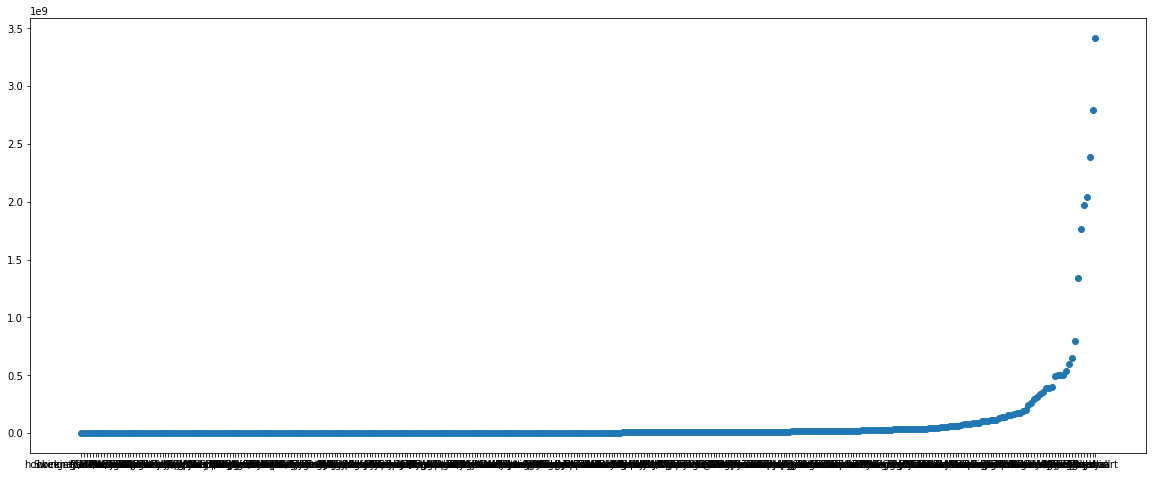

count    3.300000e+01
mean     8.670279e+08
std      8.868326e+08
min      2.072000e+06
25%      1.448917e+08
50%      7.041050e+08
75%      1.364289e+09
max      4.201662e+09
Name: sum_price, dtype: float64


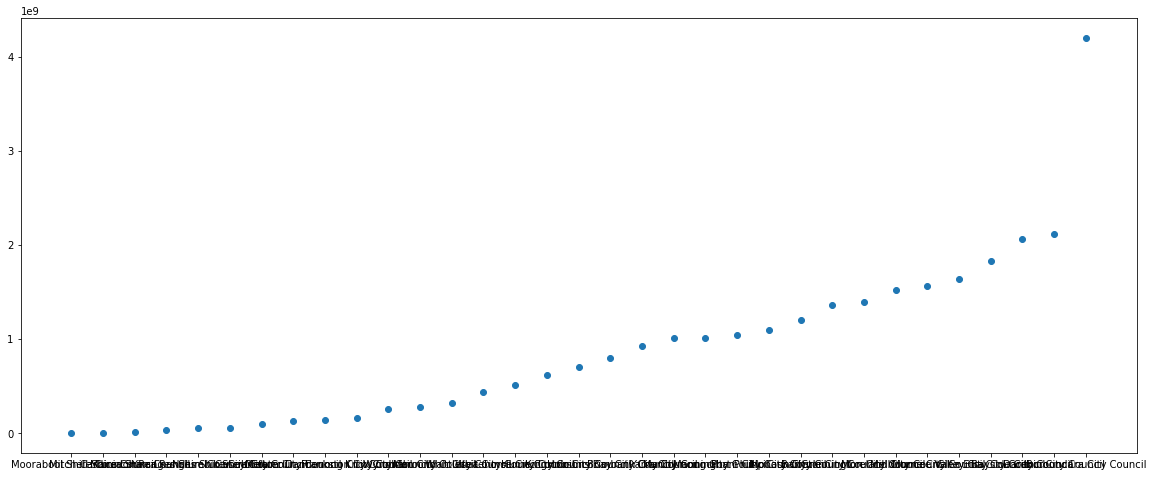

In [97]:
## ANOVA Test for METHOD & TYPE & SUBURB & REGIONNAME & SELLERG & CouncilArea - categorical vars
### H0: There is no impact of catgorical variables on Price
### H1: Via versa
cat_list = ['Method','Type','Suburb','SellerG','Regionname','CouncilArea']
#### Method
list_of_method = list(set(df['Method'].tolist()))
n_method = {}
N = len(list_of_method)
test_data = pd.DataFrame({'Method':df['Method'], 'Price':df['Price']})
test_data_ = test_data['Price'].groupby(test_data['Method']).sum().reset_index(name='sum_price')
test_data__ = test_data_.sort_values(by='sum_price',ascending=True)
print(test_data__['sum_price'].describe())
plt.figure(figsize=(20,8))
plt.scatter(test_data__['Method'],test_data__['sum_price'])
plt.show()
for key in list_of_method:
  temp_df = test_data[test_data['Method']==key]
  if temp_df.shape[0] <= 1:
    break
  else:
    transform_array = boxcox(temp_df['Price'],-0.3)
    n_method[key] = transform_array.tolist()
print("=====VAR_METHOD - ANOVA TEST: " + str(f_oneway(n_method['S'],n_method['VB'],n_method['PI'],n_method['SA'],n_method['SP'])))
if f_oneway(n_method['S'],n_method['VB'],n_method['PI'],n_method['SA'],n_method['SP'])[1] >= 0.05:
    print('Accept H0')
else: 
    print('Reject H0')
####### label encoding
df['method_label'] = df['Method'].apply(lambda x: cat_transform(x,test_data__['Method']))

#### Type
list_of_type = list(set(df['Type'].tolist()))
n_method = {}
N = len(list_of_type)
test_data = pd.DataFrame({'Type':df['Type'], 'Price':df['Price']})
test_data_ = test_data['Price'].groupby(test_data['Type']).sum().reset_index(name='sum_price')
test_data__ = test_data_.sort_values(by='sum_price',ascending=True)
print(test_data__['sum_price'].describe())
plt.figure(figsize=(20,8))
plt.scatter(test_data__['Type'],test_data__['sum_price'])
plt.show()
for key in list_of_type:
  temp_df = test_data[test_data['Type']==key]
  if temp_df.shape[0] <= 1:
    break
  else:
    transform_array = boxcox(temp_df['Price'],-0.3)
    n_method[key] = transform_array.tolist()
list_of_type
print("=====VAR_TYPE - ANOVA TEST: " + str(f_oneway(n_method['h'],n_method['u'],n_method['t'])))
if f_oneway(n_method['h'],n_method['u'],n_method['t'])[1] >= 0.05:
    print('Accept H0')
else: 
    print('Reject H0')
####### label encoding
df['type_label'] = df['Type'].apply(lambda x: cat_transform(x,test_data__['Type']))

#### Suburb
list_of_sub = list(set(df['Suburb'].tolist()))
n_method = {}
N = len(list_of_sub)
test_data = pd.DataFrame({'Suburb':df['Suburb'], 'Price':df['Price']})
test_data_ = test_data['Price'].groupby(test_data['Suburb']).sum().reset_index(name='sum_price')
test_data__ = test_data_.sort_values(by='sum_price',ascending=True)
print(test_data__['sum_price'].describe())
plt.figure(figsize=(20,8))
plt.scatter(test_data__['Suburb'],test_data__['sum_price'])
plt.show()
for key in list_of_sub:
  temp_df = test_data[test_data['Suburb']==key]
  if temp_df.shape[0] <= 1:
    break
  else:
    transform_array = boxcox(temp_df['Price'],-0.3)
    n_method[key] = transform_array.tolist()
test_data__['sum_price'].describe()
len(test_data__['Suburb'])
####### label encoding
df['Suburb_label'] = df['Suburb'].apply(lambda x: cat_transform(x,test_data__['Suburb']))

#### Regionname
list_of_sub = list(set(df['Regionname'].tolist()))
n_method = {}
N = len(list_of_sub)
test_data = pd.DataFrame({'Regionname':df['Regionname'], 'Price':df['Price']})
test_data_ = test_data['Price'].groupby(test_data['Regionname']).sum().reset_index(name='sum_price')
test_data__ = test_data_.sort_values(by='sum_price',ascending=True)
print(test_data__['sum_price'].describe())
plt.figure(figsize=(20,8))
plt.scatter(test_data__['Regionname'],test_data__['sum_price'])
plt.show()
for key in list_of_sub:
  temp_df = test_data[test_data['Regionname']==key]
  if temp_df.shape[0] <= 1:
    break
  else:
    transform_array = boxcox(temp_df['Price'],-0.3)
    n_method[key] = transform_array.tolist()
test_data__['sum_price'].describe()
len(test_data__['Regionname'])
####### label encoding
df['Regionname_label'] = df['Regionname'].apply(lambda x: cat_transform(x,test_data__['Regionname']))

#### SellerG
list_of_sub = list(set(df['SellerG'].tolist()))
n_method = {}
N = len(list_of_sub)
test_data = pd.DataFrame({'SellerG':df['SellerG'], 'Price':df['Price']})
test_data_ = test_data['Price'].groupby(test_data['SellerG']).sum().reset_index(name='sum_price')
test_data__ = test_data_.sort_values(by='sum_price',ascending=True)
print(test_data__['sum_price'].describe())
plt.figure(figsize=(20,8))
plt.scatter(test_data__['SellerG'],test_data__['sum_price'])
plt.show()
for key in list_of_sub:
  temp_df = test_data[test_data['SellerG']==key]
  if temp_df.shape[0] <= 1:
    break
  else:
    transform_array = boxcox(temp_df['Price'],-0.3)
    n_method[key] = transform_array.tolist()
test_data__['sum_price'].describe()
len(test_data__['SellerG'])
####### label encoding
df['Seller_label'] = df['SellerG'].apply(lambda x: cat_transform(x,test_data__['SellerG']))


#### CouncilArea
list_of_sub = list(set(df['CouncilArea'].tolist()))
n_method = {}
N = len(list_of_sub)
test_data = pd.DataFrame({'CouncilArea':df['CouncilArea'], 'Price':df['Price']})
test_data_ = test_data['Price'].groupby(test_data['CouncilArea']).sum().reset_index(name='sum_price')
test_data__ = test_data_.sort_values(by='sum_price',ascending=True)
print(test_data__['sum_price'].describe())
plt.figure(figsize=(20,8))
plt.scatter(test_data__['CouncilArea'],test_data__['sum_price'])
plt.show()
for key in list_of_sub:
  temp_df = test_data[test_data['CouncilArea']==key]
  if temp_df.shape[0] <= 1:
    break
  else:
    transform_array = boxcox(temp_df['Price'],-0.3)
    n_method[key] = transform_array.tolist()
test_data__['sum_price'].describe()
len(test_data__['CouncilArea'])
####### label encoding
df['CouncilArea'] = df['CouncilArea'].apply(lambda x: cat_transform(x,test_data__['CouncilArea']))

###2. Apply linear regression model for prediction with hold out & cross validation

====== Normal Distribution & Correlation with Price: Rooms======


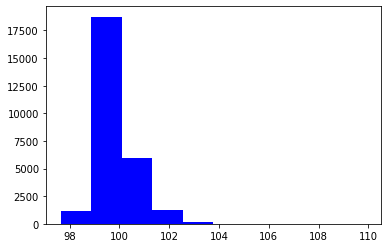

Correlation Coef: 0.5440997659250718


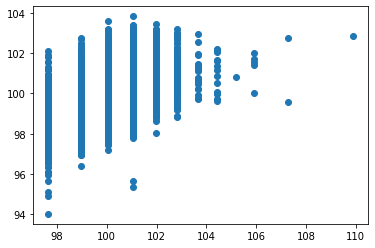

====== Normal Distribution & Correlation with Price: Price======


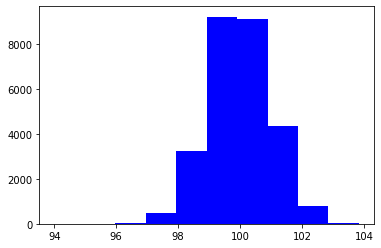

Correlation Coef: 1.0


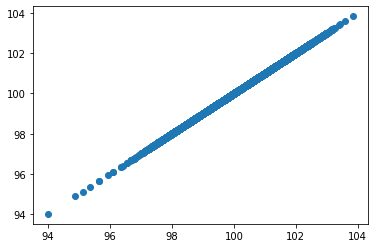

====== Normal Distribution & Correlation with Price: Distance======


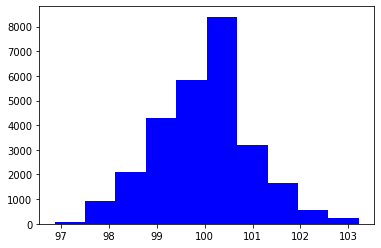

Correlation Coef: -0.1751666000132669


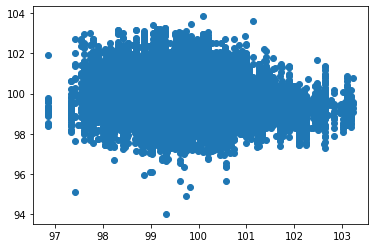

====== Normal Distribution & Correlation with Price: Postcode======


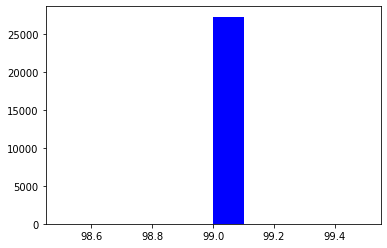

Correlation Coef: nan


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


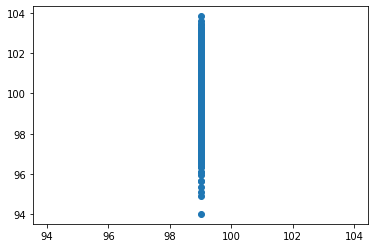

====== Normal Distribution & Correlation with Price: Bedroom2======


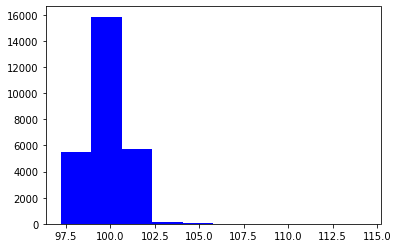

Correlation Coef: 0.434563071236884


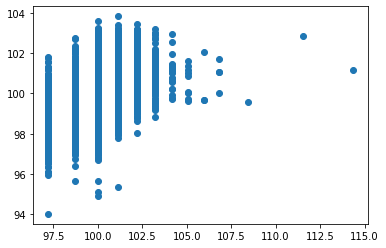

====== Normal Distribution & Correlation with Price: Bathroom======


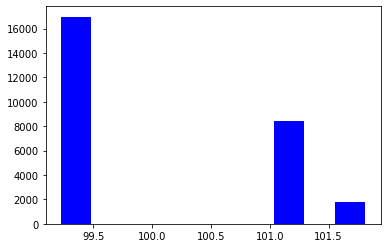

Correlation Coef: 0.3498858463443327


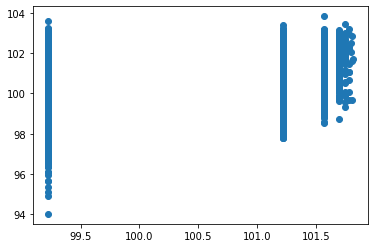

====== Normal Distribution & Correlation with Price: Car======


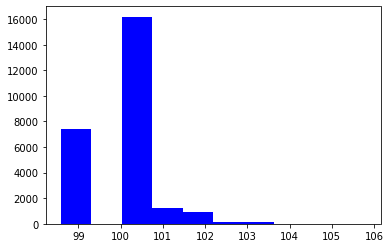

Correlation Coef: 0.23220349375207228


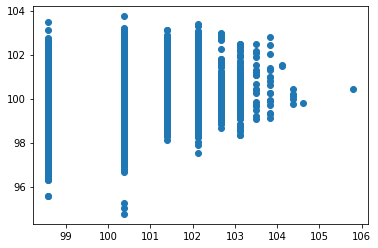

====== Normal Distribution & Correlation with Price: Landsize======


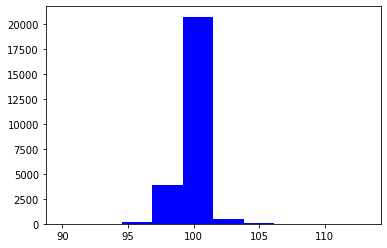

Correlation Coef: 0.06850436932001334


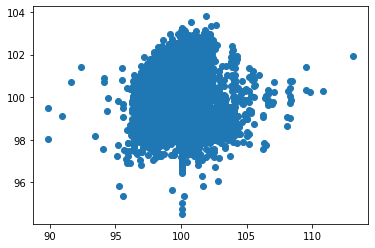

====== Normal Distribution & Correlation with Price: BuildingArea======


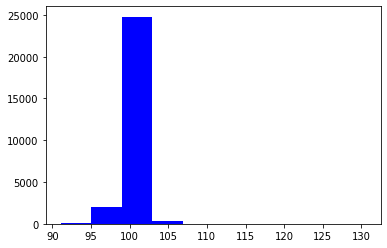

Correlation Coef: 0.3320145368803432


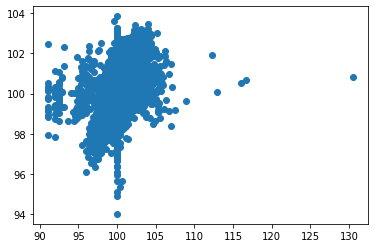

====== Normal Distribution & Correlation with Price: CouncilArea======


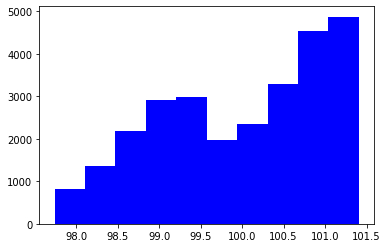

Correlation Coef: 0.30156702040597555


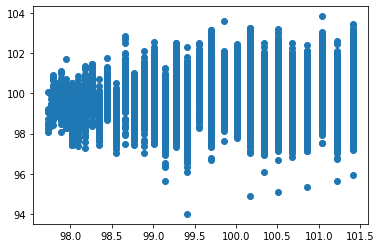

====== Normal Distribution & Correlation with Price: Lattitude======


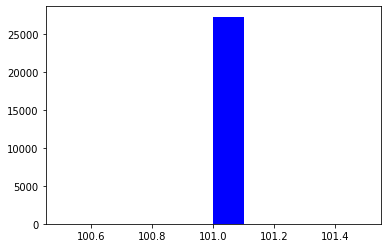

Correlation Coef: nan


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


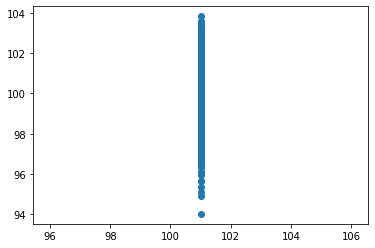

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


====== Normal Distribution & Correlation with Price: Longtitude======


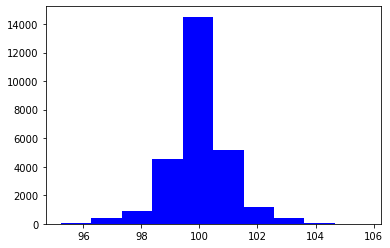

Correlation Coef: 0.2180577834871804


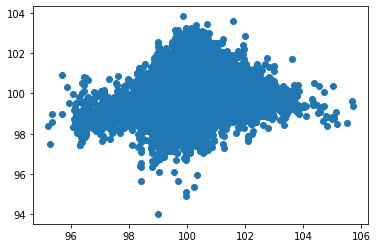

====== Normal Distribution & Correlation with Price: Propertycount======


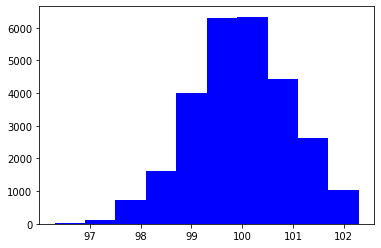

Correlation Coef: -0.05060840998870655


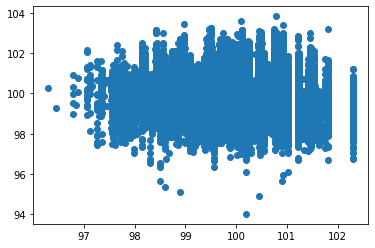

====== Normal Distribution & Correlation with Price: yearbuild_grp======


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


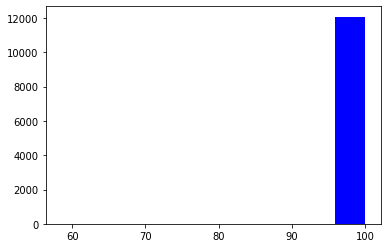

Correlation Coef: -0.004692777873296959


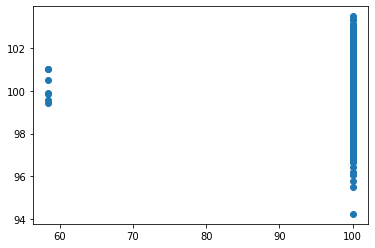

====== Normal Distribution & Correlation with Price: method_label======


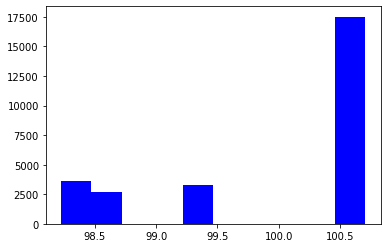

Correlation Coef: 0.0616765783768057


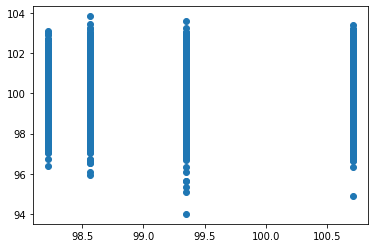

====== Normal Distribution & Correlation with Price: type_label======


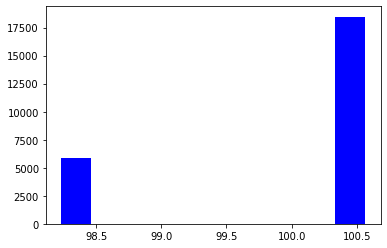

Correlation Coef: 0.5047678241737115


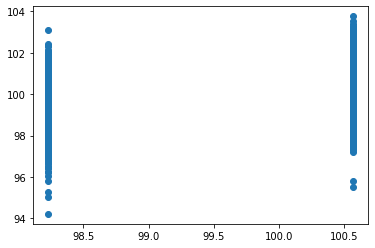

====== Normal Distribution & Correlation with Price: Suburb_label======


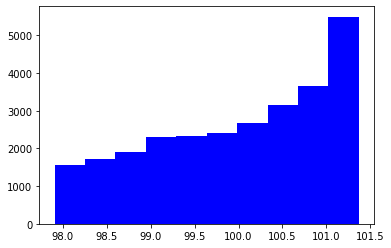

Correlation Coef: 0.2955472360089661


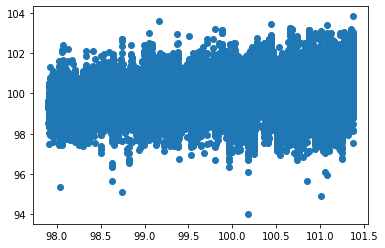

====== Normal Distribution & Correlation with Price: Regionname_label======


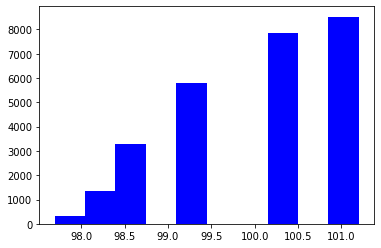

Correlation Coef: 0.20397597463088724


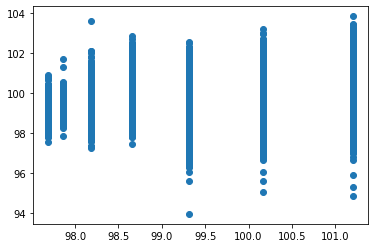

====== Normal Distribution & Correlation with Price: Seller_label======


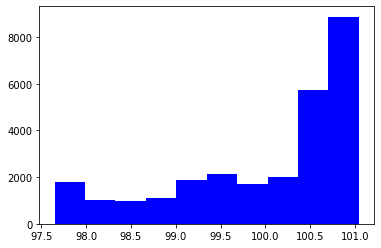

Correlation Coef: 0.19930154634919103


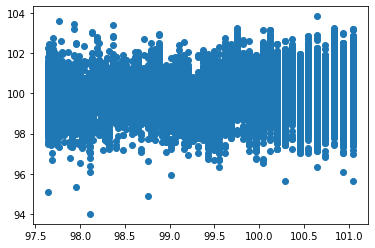

In [98]:
#Check correlation btw price and the rest
list_of_corr_col = df.select_dtypes(include=['float64','int64']).columns.tolist()

for key in [list_of_corr_col for list_of_corr_col in list_of_corr_col if list_of_corr_col not in ['YearBuilt']]:
  temp_list = col_filtering(df,key)
  var_price = box_cox_transfrom(temp_list,'Price','Price')
  var_target = box_cox_transfrom(temp_list,key,key)
  print("====== Normal Distribution & " + "Correlation with Price: " + key + "======")
  plt.hist(var_target,color='blue')
  plt.show()
  # print("Correlation sco: Price & "+key+"======")
  # print(np.corrcoef(var_price,var_target,rowvar=False)[0][1])
  print("Correlation Coef: " + str(np.corrcoef(var_price,var_target,rowvar=False)[0][1]))
  plt.scatter(var_target,var_price)
  plt.show()

######+ Remark:
######1. Check detail of correlation btw Price & Others/ ANOVA Test with variables Method & Type -> pick feature
######2. Training LR model

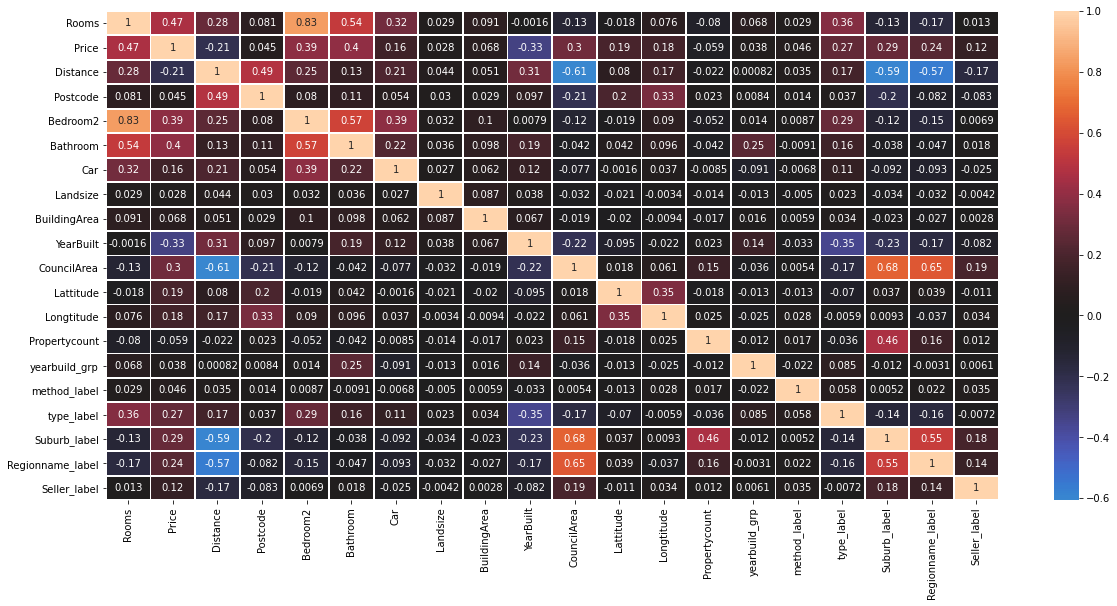

In [99]:
#Correlation draft check
plt.figure(figsize=(20,9))
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            center=0,  annot= True, linewidths=0.8 )

###### Pick independent vars
+ Drop vars with weak correlation: Distance, YearBuilt, Landzise, Propertycount, Buildingarea, CouncilArea.

=======Dependent Var Distribution - Price========


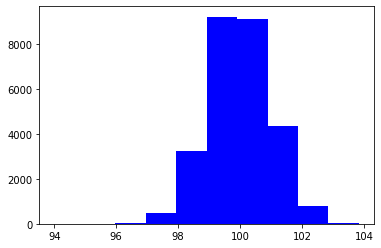

[-161.90940972]
[[ 5.45584813e-01 -3.32813780e-04 -1.25766525e-01  2.02739997e-01
   2.66106823e-02  2.12693469e+00  1.22839462e+00 -4.49220091e-02
   4.52127450e-02  3.08682028e-01  4.04541168e-03  1.08528003e-01
   1.64598007e-03]]


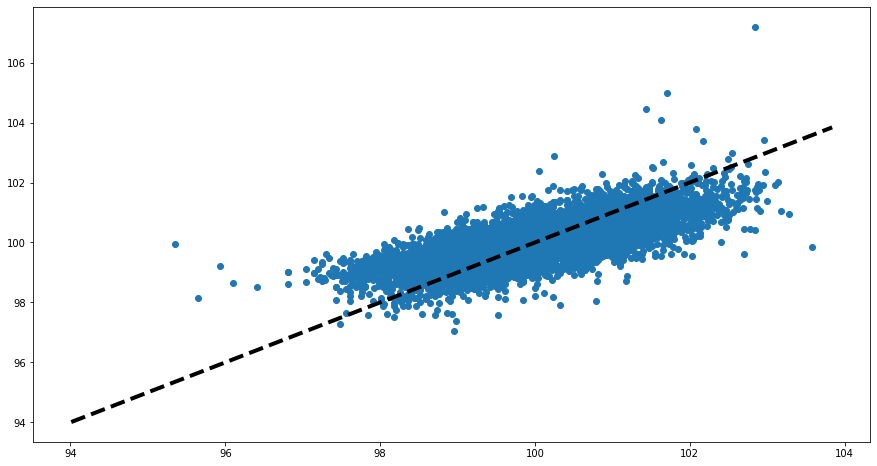

RMSE: 0.46551496723121555
y_max: 103.5845875406211
y_min: 95.35406484856061
R2 score: 0.5397015942293327


In [100]:
# LR MODEL
LR = LinearRegression()
df1 = df.drop(['Distance','YearBuilt','Landsize','Propertycount','BuildingArea','Suburb','Address','Type','Method','SellerG','Date','CouncilArea','Regionname'],axis=1)
# PREPARATION FOR X ,Y 
x = df1.drop(['Price'],axis=1)

y_col = df1[['Price']]
y = box_cox_transfrom(y_col,'Price','Price')
plt.hist(y,color='blue')
print("=======Dependent Var Distribution - Price========")
plt.show()

# HOLD OUT
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
LR.fit(x_train,y_train)
print(LR.intercept_)
print(LR.coef_)

predictions = LR.predict(x_test)
plt.figure(figsize=(15,8))
plt.scatter(y_test, predictions)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.show()
print("RMSE: " + str(mean_squared_error(y_test, predictions)))
print("y_max: " + str(y_test.max()))
print("y_min: " + str(y_test.min()))
print("R2 score: " + str(r2_score(y_test, predictions)))

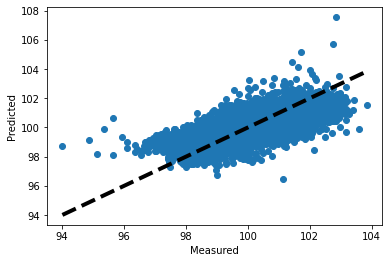

In [101]:
# CROSS VALIDATION PREDICT
predicted = cross_val_predict(LR, x, y, cv=5)
fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [102]:
# CROSS VALIDATION SCORE WITH 5-FOLD
scores = cross_val_score(LR, x, y, cv=5)
print('=========================================================')
print(scores)
print("R2 - Average score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.58454741 0.4593551  0.52166346 0.52329424 0.51453572]
R2 - Average score: 0.52 (+/- 0.08)


###### Model Performance based on Hold out vs Cross validation (5-Fold) is quite the same:
+ R2 Score - Hold out : 0.54
+ R2 Score - Cross validation (5-Fold) : 0.52

###3. Apply linear regression model for prediction using PCA with hold out & cross validation

+ PCA is used in exploratory data analysis and for making predictive models. It is commonly used for dimensionality reduction by projecting each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible

In [ ]:
col_num = len(x.columns)
pca = PCA(n_components=col_num)
x_forpca = x
principalcomps = pca.fit_transform(x_forpca)
print(pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.show()

+ svd_solver='auto': The solver is selected by a default policy based on X.shape and n_components: if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ‘randomized’ method is enabled. Otherwise the exact full SVD is computed and optionally truncated afterwards.
+ Percentage of variance explained by each of the selected components

In [ ]:
# HOLD OUT
LR1 = LinearRegression()
principalcomps_df = pd.DataFrame(data=principalcomps)
x_train_pca, x_test_pca, y_train, y_test = train_test_split(principalcomps_df, y, test_size=0.3)
LR1.fit(x_train_pca,y_train)
print(LR1.intercept_)
print(LR1.coef_)

predictions_pca = LR1.predict(x_test_pca)
plt.figure(figsize=(15,8))
plt.scatter(y_test, predictions_pca)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.show()
print("RMSE: " + str(mean_squared_error(y_test, predictions_pca)))
print("y_max: " + str(y_test.max()))
print("y_min: " + str(y_test.min()))
print("R2 score: " + str(r2_score(y_test, predictions_pca)))

In [ ]:
# CROSS VALIDATION SCORE WITH 5-FOLD
scores_pca = cross_val_score(LR1, principalcomps_df, y, cv=5)
print('=========================================================')
print(scores_pca)
print("R2 - Average score PCA: %0.2f (+/- %0.2f)" % (scores_pca.mean(), scores_pca.std() * 2))

###4. Visualize residential & homoscedasticity
*italicized text*

In [ ]:
# Plot Residual
plt.figure(figsize=(10,8))
plt.scatter(LR.predict(x_train),LR.predict(x_train)-y_train,c='b',s=40)
plt.scatter(LR.predict(x_test),LR.predict(x_test)-y_test,c='g')
plt.hlines(y=0,xmin=92,xmax=110)
plt.title('Residual Plot for Train & Test data')
plt.show()

+ As the above plot the residual has a constant variance and meet homoscedasticity.

###5.Tune parameter of linear regression model

+ Using GridsearchCV to tune LR model

In [ ]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
LR_hyperparam = GridSearchCV(LR,parameters, cv=10)
LR_hyperparam.fit(x_train,y_train)

predictions_hyperparam = LR_hyperparam.predict(x_test)
plt.figure(figsize=(15,8))
plt.scatter(y_test, predictions_hyperparam)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.show()
print("RMSE: " + str(mean_squared_error(y_test, predictions_hyperparam)))
print("r2 / variance : " + str(LR_hyperparam.best_score_))
print("R2 score: " + str(r2_score(y_test, predictions_hyperparam)))

###6.Summary

In [ ]:
print('===========================LINEAR REGRESSION=================================')
print("R2 score Hold Out - LR: 0.5397015942293327")
print("R2 score Cross Validation - LR: 0.52")
print('===========================LINEAR REGRESSION APPLIED PCA=====================')
print("R2 score Hold Out - LR PCA: 0.5417912838942398")
print("R2 score Cross Validation - LR: 0.52")
print('===========================LINEAR REGRESSION APPLIED GRID SEARCH=============')
print("R2 score - LR GridSearchCV : 0.5338457325454009")

+ There is not a diffence btw 3 methods of LR model since R2 not increase much when changing to PCA or applying GridSearch.
+ The R2 is quite low so LR may not suitable for prediction.